# Token Alignment

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from genparse import CFG, FST, EPSILON, Float, CFGLM, add_EOS, prefix_transducer
from genparse.cfglm import locally_normalize
from genparse.util import LarkStuff, hf_tokenizer
from arsenal import iterview, timeit
from collections import Counter
from mockup import about, bpe2term_approx, show_grammar
from original_prefix_grammar import PrefixGrammar

In [155]:
lark_stuff = LarkStuff(r"""

start: NAME

NAME: /(a|b)*c/

""")

cfg = lark_stuff.convert().renumber()
c2t = lark_stuff.transducer(ignore='', decay=.52).renumber.trim
cfg_t = (c2t @ cfg).trim()

In [156]:
cfg

Grammar {
  1.0: 0 → NAME
}

In [160]:
show_grammar(cfg_t.prefix_grammar.trim(), showzero=True)#.cnf

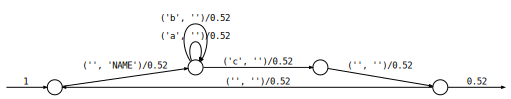

In [142]:
c2t

In [143]:
c2t.total_weight()

-0.6463812067170596

In [144]:
(FST.from_string('aaacbbbc', Float) @ c2t).project(1).epsremove.trim

1.0 ('NAME',)
-1.8279039999999986


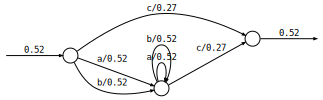

In [145]:
for x, w in cfg.cnf.language(5).items():
    print(w, x)
    xx = (c2t @ FST.from_string(x, Float)).project(0).epsremove.trim
    print(xx.total_weight())
    display(xx)

In [146]:
#cfg_t.cnf.language(5)

In [147]:
print(cfg_t.agenda().__str__(style_value=lambda k, v: (colors.light.red % v) if v > 1 or v < 0 else v))

Chart {
  (0, Other(x=0), 2): 1.4037269924165637e+18,
  (2, '', 2): 1.04,
  b: 1,
  c: 1,
  a: 1,
  (3, '', 1): 0.52,
  (2, '', 3): 0.52,
  (0, 'NAME', 2): 0.52,
  (0, 0, 2): 0.52,
}


In [153]:
show_grammar(cfg_t)

In [148]:
cfg_t

Grammar {
  1.0: (0, 0, 2) → (0, 'NAME', 2)
  1: (0, Other(x=0), 2) → (0, 0, 2)
  1: (0, Other(x=0), 2) → (0, Other(x=0), 2) (2, '', 2)
  1: (0, Other(x=0), 3) → (0, Other(x=0), 2) (2, '', 3)
  1: (0, Other(x=0), 1) → (0, Other(x=0), 3) (3, '', 1)
  0.52: 0 → (0, Other(x=0), 1)
  0.52: (0, 'NAME', 2) → 
  0.52: (2, '', 2) → a
  0.52: (2, '', 2) → b
  0.52: (2, '', 3) → c
  0.52: (3, '', 1) → 
}

In [149]:
#cfg_t.prefix_grammar.trim()

In [150]:
cfg.cnf.language(5)

key,value
"('NAME',)",1.0


In [151]:
cfg_t.cnf.language(3)

key,value
"('c',)",0.07311616000000001
"('b', 'c')",0.03802040320000001
"('a', 'c')",0.03802040320000001
"('b', 'b', 'c')",0.019770609664000002
"('b', 'a', 'c')",0.019770609664000002
"('a', 'b', 'c')",0.019770609664000002
"('a', 'a', 'c')",0.019770609664000002


In [152]:
cfg_t.prefix_grammar.trim().cnf

Grammar {

}

In [131]:
#show_grammar(cfg_t.prefix_grammar.trim())

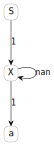

In [132]:
tmp = CFG.from_string('', Float)
tmp.add(1, 'S', 'X')
tmp.add(np.nan, 'X', 'X')
tmp.add(1, 'X', 'a')
tmp._unary_graph()

In [100]:
tmp._unary_graph().closure_reference()

key,value
"('X', 'X')",nan
"('X', 'a')",nan
"('X', 'S')",nan
"('a', 'X')",nan
"('a', 'a')",nan
"('a', 'S')",nan
"('S', 'X')",nan
"('S', 'a')",nan
"('S', 'S')",nan


In [101]:
tmp._unary_graph().closure_scc_based()

key,value
"('X', 'X')",nan
"('X', 'a')",nan
"('a', 'X')",nan
"('a', 'a')",nan
"('S', 'S')",1.0
"('S', 'X')",nan
"('S', 'a')",nan


In [105]:
np.nan > 0, np.nan < 0, np.nan == 0

(False, False, False)

In [3]:
x = 'SELECT * FROM data'

In [4]:
# g = CFG.from_string("""

# 1: S -> a

# """, Float)

# t = FST(Float)
# t.add_I(0, 1)
# t.add_arc(0, ('a', ''), 1, 1)
# t.add_arc(1, ('', 'b'), 1, 0.5)
# t.add_F(1, 1)

# (g @ t).language(10)

In [10]:
lark_stuff = LarkStuff(r"""

start: "SELECT" " " NAME "X"

NAME: /b+/

""")

cfg = lark_stuff.convert().renumber()
c2t = lark_stuff.transducer(ignore='', decay=.9).renumber
cfg_t = (c2t @ cfg).trim()

#display(cfg_t)

display(cfg_t.language(25))

#pg = locally_normalize(cfg_t.cnf).prefix_grammar.trim()
#pg = pg.cnf
#display(pg)

#print(cfg_t.V)
pg = PrefixGrammar(cfg_t)

pg('SELECT bbb')   # should be nonzero...

key,value
"('S', 'E', 'L', 'E', 'C', 'T', ' ', 'b', 'X')",0.10941898913151245
"('S', 'E', 'L', 'E', 'C', 'T', ' ', 'b', 'b', 'X')",0.09847709021836122
"('S', 'E', 'L', 'E', 'C', 'T', ' ', 'b', 'b', 'b', 'X')",0.0886293811965251
"('S', 'E', 'L', 'E', 'C', 'T', ' ', 'b', 'b', 'b', 'b', 'X')",0.07976644307687258
"('S', 'E', 'L', 'E', 'C', 'T', ' ', 'b', 'b', 'b', 'b', 'b', 'X')",0.07178979876918533
"('S', 'E', 'L', 'E', 'C', 'T', ' ', 'b', 'b', 'b', 'b', 'b', 'b', 'X')",0.0646108188922668
"('S', 'E', 'L', 'E', 'C', 'T', ' ', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'X')",0.058149737003040124
"('S', 'E', 'L', 'E', 'C', 'T', ' ', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'X')",0.05233476330273613
"('S', 'E', 'L', 'E', 'C', 'T', ' ', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'X')",0.04710128697246251
"('S', 'E', 'L', 'E', 'C', 'T', ' ', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'X')",0.04239115827521626


0.8862702707617798

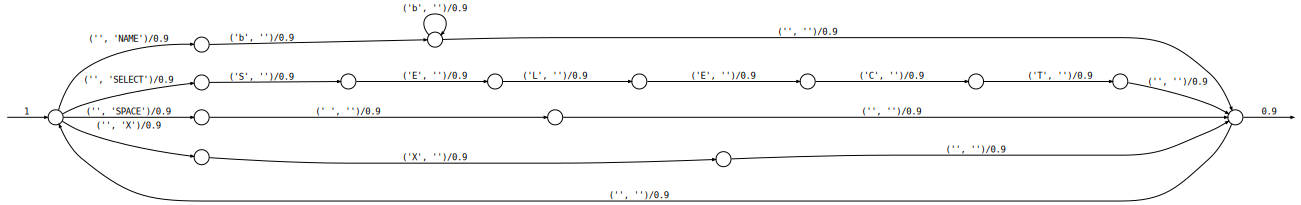

In [6]:
c2t

In [ ]:
c2t(None, ('NAME',)).epsremove.trim.total_weight()

In [ ]:
cfg_t.language(19)

In [ ]:
cfg_t.cnf.trim()

In [ ]:
locally_normalize(cfg_t.cnf).treesum()

In [ ]:
locally_normalize(cfg_t.cnf).trim()

In [ ]:
locally_normalize(cfg_t.cnf).prefix_grammar.trim()

## Lexing

In [ ]:
lark_stuff = LarkStuff(r"""

start: "SELECT" WS STAR WS "FROM" WS NAME WS EOS

EOS: "</s>"
NAME: /[A-Za-z]+/
STAR: "*"
WS: /[ ]/

""")

In [ ]:
cfg = lark_stuff.convert().renumber()

In [ ]:
c2t = lark_stuff.transducer(ignore='', decay=.7); len(c2t.states)

In [ ]:
#c2t

The `lark` library will only lex it one way because it has a deterministic semantics for prioritized lexing:

In [ ]:
list(lark_stuff.lex(x))

However, this string can lex many different ways:

In [ ]:
ambig = (FST.from_string(x, Float) @ c2t).trim.project(1).epsremove.trim.to_cfg().cnf.language(15)

In [ ]:
#ambig

It might be fine to allow ambiguous lexing because very few of the possibly lexing options will survive the parser.

In [ ]:
for y in ambig:
    v = cfg.prefix_weight(y)   # show all options with a nonzero prefix weight
    if v == 0: continue
    print(v, y)

In [ ]:
#((FST.from_string('SELECT', Float) @ c2t) @ P.T @ cfg).trim().cnf.language(15)

In [ ]:
#(P.T @ cfg).trim().cnf.language(100)

In [ ]:
cfg_t = (c2t.renumber @ cfg).trim()

In [ ]:
#cfg_t.cnf.trim().language(13)

In [ ]:
#cfg_t.V

In [ ]:
#cfg_t.agenda(maxiter=100)

In [ ]:
#cfg_t.prefix_grammar('SEL')   # XXX: we what to run this, but the composition with c2t results in divergence!

In [ ]:
#chart = cfg_t.agenda()
#chart

In [ ]:
#chart = cfg_t.agenda(maxiter=100)

In [ ]:
#for block in cfg_t.dependency_graph().blocks():
#    if any( chart[y] > 1.001 for y in  block ):
#        print(block, [chart[y] for y in block])

In [ ]:
#show_grammar(cfg_t)

In [ ]:
#cfg_t.agenda()

In [ ]:
#cfg_t.cnf.trim().prefix_grammar.cnf('SELECT * FR')

In [ ]:
cfg_t.trim().cnf('SELECT * FROM data </s>')

In [ ]:
pg = locally_normalize(cfg_t.cnf.trim()).prefix_grammar.trim()
pg = pg.cnf

In [ ]:
pg('SEL')

In [ ]:
pg('SELECT *')

In [ ]:
lm = CFGLM(add_EOS(locally_normalize(cfg_t.cnf.trim())))

In [ ]:
for _ in range(10):
    print(''.join(lm.sample()))

In [ ]:
lm.p_next('SELECT * FROM ')

In [ ]:
#cfg_t.cnf.language(13)

In [ ]:
cfg_t('SELECT * FROM data </s>')

In [ ]:
#lm = CFGLM(cfg_t)

## BPE Basics

In [ ]:
hf_tk = hf_tokenizer()
tokenizer = hf_tk.tokenizer

In [ ]:
b2c = hf_tk.fst
len(b2c.states)

In [ ]:
x = 'SELECT * FROM data'
b = tokenizer.encode(x)
b

In [ ]:
[tokenizer.decode([bb]) for bb in b]

In [ ]:
#FST.from_pairs(hf_tk.pairs[1000:1020], Float).star().epsremove.trim

In [ ]:
with timeit('composition'):
    c = FST.from_string(tuple(b), Float) @ b2c
about(c)

In [ ]:
c.trim

We can build this "transducer" more efficiently

In [ ]:
t = bpe2term_approx(tokenizer, tokenizer.encode(x)).epsremove.trim
t

## BPE Ambiguity

In [ ]:
with timeit('composition'):
    bs = b2c @ FST.from_string(x, Float)
with timeit('trim'):
    bs.trim
about(bs)

In [ ]:
#bs.trim

The automaton below describes all the BPE sequences that generate the string `x`:

In [ ]:
bs.trim.project(0).epsremove.trim

To see all the BPE sequences that generate `x` run the cell below:

In [ ]:
#for y in bs.trim.project(0).epsremove.trim.to_cfg().language(10):
#    print(tokenizer.decode(y), y)

In [ ]:
#show_grammar(cfg_t, chart)

In [ ]:
#cfg_t

## BPE-to-Terminal

In [ ]:
#FST.from_string(tuple(b), Float) @ b2c

In [ ]:
#t.to_cfg().cnf.language(50)

In [ ]:
#e.trim.renumber.to_cfg().trim().cnf.language(55)

In [ ]:
#e.trim.renumber.project(0).epsremove.trim

In [ ]:
#e.trim.renumber.project(0).epsremove.trim.to_cfg().trim().cnf.language(6)

In [ ]:
#tmp = c2t('SELECT', None).trim.epsremove.trim
#tmp

In [ ]:
#tmp = c2t('SELECT\n\t\r FROM 1 2', None).trim.epsremove.trim#.min
#tmp

In [ ]:
#tmp = c2t('SELECT\nFROM', ('KEYWORD', 'KEYWORD'))
#tmp

In [ ]:
# random.seed(8675309)
# bpe_small = random.sample(T, 10)
# b2c_small = bpe_wfst(bpe_small).renumber
# len(b2c_small.states)

In [ ]:
#bpe_small

In [ ]:
#b2c_small

In [ ]:
#c = FST.from_string('zon ankles Turtles purple', Float).renumber

In [ ]:
#len((b2c_small @ c).states), len((b2c_small @ c).trim.states)

In [ ]:
#(b2c_small @ c).trim

In [ ]:
# N = lambda x: abs(hash(x)) % 3
# A = lambda x: abs(hash(x)) % 2
# B = lambda x: abs(hash(x)) % 7

# bbb = b2c_small.coarsen(N, A, B)
# ccc = c.coarsen(N = lambda x: abs(hash(x)) % 5, A = B, B = B)

In [ ]:
#bbb

In [ ]:
#ccc

In [ ]:
#monster = b2c @ c2t

In [ ]:
#len(monster.states), len(monster.trim.states)

In [ ]:
#monster_baby = FST.from_string((5188,), Float).renumber @ monster 

In [ ]:
#len(monster_baby.states), len(monster_baby.trim.states)

In [ ]:
#c = FST.from_string(x, Float).renumber
#c

In [ ]:
#query = b2c @ c

In [ ]:
#query.trim

In [ ]:
#len(query.states), len(query.trim.states)

In [ ]:
#terminals = (c @ lark_stuff.transducer()).trim
#terminals

In [ ]:
#list(lark_stuff.lex(x))

In [ ]:
#bpe2terminal = query.trim @ terminals

In [ ]:
#len(bpe2terminal.states), len(bpe2terminal.trim.states)

In [ ]:
#bpe2terminal.trim